## Physics Performance Notebook 
Notebook to evaluate the perfomance of full sim training. <br>
Need as imput: the training model (best_valid_model.pt) and the input graph (stored PF properties) <br>
uses pyjet to recluster the jets after we apply puppi and GNN weights


Load all needed environments

In [1]:
import argparse
import torch
from torch_geometric.data import DataLoader
#import models_ggnn_oldpipe as models
import models_fastsim as models
import utils
import matplotlib
from copy import deepcopy
import os
import copy
import uproot
import awkward as ak

#matplotlib.use("pdf")
import numpy as np
import random
import pickle
import joblib
from timeit import default_timer as timer
from tqdm import tqdm

import matplotlib as mpl
import imageio

#mpl.use("pdf")
import matplotlib.pyplot as plt
import mplhep as hep

hep.set_style(hep.style.CMS)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())

from pyjet import cluster, DTYPE_PTEPM
from collections import OrderedDict
import scipy.stats

True


/tmp/ipykernel_245/2404713099.py:29: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style(hep.style.CMS)


define the deltaPhi and deltaR functions

In [3]:
def deltaPhiNew(dphis):
    dphis = np.where(dphis > np.pi, dphis - 2*np.pi, dphis)
    dphis = np.where(dphis <-np.pi, dphis + 2*np.pi, dphis)
    return dphis

def deltaRNew(detas, dphis):
    """
    calculate the deltaR based on the input deta and phi
    """
    dphis = deltaPhiNew(dphis)
    dR = np.sqrt(detas**2 + dphis**2)
    return dR

Do some preprocessings of data, needed for the model <br>
@YB: Why do we need to add the masking ??

In [4]:
def generate_mask(dataset):
    # how many LV and PU to sample
    # dataset = deepcopy(dataset_org)
    for graph in dataset:
        LV_index = graph.LV_index
        PU_index = graph.PU_index
        original_feature = graph.x[:, 0:graph.num_feature_actual]

        num_select_LV = 5
        num_select_PU = 50

        if LV_index.shape[0] < num_select_LV or PU_index.shape[0] < num_select_PU:
            num_select_LV = min(LV_index.shape[0], num_select_LV)
            num_select_PU = min(PU_index.shape[0], num_select_PU)

        # generate the index for LV and PU samples for training mask
        gen_index_LV = random.sample(range(LV_index.shape[0]), num_select_LV)
        selected_LV_train = LV_index[gen_index_LV]

        gen_index_PU = random.sample(range(PU_index.shape[0]), num_select_PU)
        selected_PU_train = PU_index[gen_index_PU]

        training_mask = np.concatenate((selected_LV_train, selected_PU_train), axis=None)
        #print(training_mask)

        # construct mask vector for training and testing
        mask_training = torch.zeros(graph.num_nodes, 1)
        mask_training[[training_mask.tolist()]] = 1

        x_concat = torch.cat((original_feature, mask_training), 1)
        graph.x = x_concat

        
        # mask the puppiWeight as default Neutral(here puppiweight is actually fromLV in ggnn dataset)
        puppiWeight_default_one_hot_training = torch.cat((torch.zeros(graph.num_nodes, 1),
                                                          torch.zeros(graph.num_nodes, 1),
                                                          torch.ones(graph.num_nodes, 1)), 1)
        puppiWeight_default_one_hot_training = puppiWeight_default_one_hot_training.type(torch.float32)
        
        #mask the pdgID for charge particles
        pdgId_one_hot_training = torch.cat((torch.zeros(graph.num_nodes, 1),
                                                          torch.zeros(graph.num_nodes, 1),
                                                          torch.ones(graph.num_nodes, 1)), 1)       
        pdgId_one_hot_training = pdgId_one_hot_training.type(torch.float32)

        #pf_dz_training_test=torch.clone(original_feature[:,6:7])
        #pf_dz_training_test = torch.zeros(graph.num_nodes, 1)    
        

        # -4 is for one hot encoding of fromLV and one mask; -1 is for final puppiweight
        #default_data_training = torch.cat(
         #   (original_feature[:, 0:(graph.num_features - 4 - 1)], puppiWeight_default_one_hot_training,
         #    original_feature[:, -1].view(-1, 1)), 1)
        #default_data_training = torch.cat(
        #     (original_feature[:, 0:(graph.num_feature_actual - 7)],pdgId_one_hot_training, pf_dz_training_test ,puppiWeight_default_one_hot_training), 1)
        default_data_training = torch.cat(
             (original_feature[:, 0:(graph.num_feature_actual - 6)],pdgId_one_hot_training, puppiWeight_default_one_hot_training), 1)
        
        concat_default = torch.cat((graph.x, default_data_training), 1)
        graph.x = concat_default

In [5]:
def generate_neu_mask(dataset):
    # all neutrals with pt cuts are masked for evaluation
    for graph in dataset:
        nparticles = graph.num_nodes
        graph.num_feature_actual = graph.num_features
        Neutral_index = graph.Neutral_index
        Neutral_feature = graph.x[Neutral_index]
        Neutral_index = Neutral_index[torch.where(Neutral_feature[:, 2] > 0.5)[0]]

        mask_neu = torch.zeros(nparticles, 1)
        mask_neu[Neutral_index, 0] = 1
        graph.mask_neu = mask_neu

    return dataset

Load the model

In [6]:
class Args(object):
    def __init__(self, model_type = 'Gated', do_boost=False, extralayers=False):
        self.model_type = model_type
        self.num_layers = 2
        self.batch_size = 1
        self.hidden_dim = 20
        self.dropout = 0
        self.opt = 'adam'
        self.weight_decay = 0
        self.lr = 0.01
        self.do_boost = do_boost
        self.extralayers = extralayers

In [7]:
args = Args()

In [8]:
class PerformanceMetrics(object):
    def __init__(self):
        pt = 0.
        pt_diff = 0.
        mass_diff = 0.
        dR_diff = 0.

cluster the jets based on the array of pt, eta, phi,
of all particles (masses are assumed to be zero),
 with pyjet clustering algo

In [9]:
def clusterJets(pt, eta, phi, ptcut=0., deltaR=0.4):
    """
    cluster the jets based on the array of pt, eta, phi,
    of all particles (masses are assumed to be zero),
    with pyjet clustering algo
    """
    # cleaning zero pt-ed objects
    pt_wptcut   = pt[pt > ptcut]
    eta_wptcut  = eta[pt > ptcut]
    phi_wptcut  = phi[pt > ptcut]
    mass_wptcut = np.zeros(pt_wptcut.shape[0])
    
    event = np.column_stack((pt_wptcut, eta_wptcut, phi_wptcut, mass_wptcut))
    event.dtype = DTYPE_PTEPM
    sequence = cluster(event, R=deltaR, p=-1)
    jets = sequence.inclusive_jets(ptmin=30)
    
    return jets

def deltaPhi(phi1, phi2):
    dphi = phi1 - phi2
    while dphi > np.pi:
        dphi -= 2 * np.pi
    while dphi < -np.pi:
        dphi += 2 * np.pi
    return dphi

def deltaR(eta1, phi1, eta2, phi2):
    """
    calculate the deltaR between two jets/particles
    """
    deta = eta1 - eta2
    dphi = phi1 - phi2
    while dphi > np.pi:
        dphi -= 2 * np.pi
    while dphi < -np.pi:
        dphi += 2 * np.pi
    return np.hypot(deta, dphi)

def deltaRJet(jet1, jet2):
    """
    calculate the deltaR of the two PseudoJet
    """
    return deltaR(jet1.eta, jet1.phi, jet2.eta, jet2.phi)

def matchJets(jets_truth, jets_reco, dRcut=0.1):
    """
    match the jets in jets_reco to jets_truth,
    based on the deltaR
    """
    matched_indices = []
    
    jets_truth_indices = list(range(len(jets_truth)))
    jets_reco_indices  = list(range(len(jets_reco)))
    
    for ijet_reco in jets_reco_indices:
        for ijet_truth in jets_truth_indices:
            #print("deltR between {} and {} is {}".format(ijet_truth, ijet_reco, deltaRJet(jets_truth[ijet_truth], jets_reco[ijet_reco])))
            if deltaRJet(jets_truth[ijet_truth], jets_reco[ijet_reco]) < dRcut:
                matched_indices.append((ijet_truth, ijet_reco))
                jets_truth_indices.remove(ijet_truth)
                break
    
    return matched_indices

def compareJets(jets_truth, jets_reco, dRcut=0.1):
    """
    match jets between truth and reco using matchJets,
    and then compared the matched deltaR, pt, and mass
    """
    performances = []
    
    matched_indices = matchJets(jets_truth, jets_reco, dRcut=dRcut)
    for ijet_truth, ijet_reco in matched_indices:
        perf = PerformanceMetrics()
        perf.pt_truth = jets_truth[ijet_truth].pt
        perf.mass_diff =  (jets_reco[ijet_reco].mass - jets_truth[ijet_truth].mass)/(jets_truth[ijet_truth].mass+1e-6)
        perf.pt_diff   =  (jets_reco[ijet_reco].pt   - jets_truth[ijet_truth].pt)/(jets_truth[ijet_truth].pt+1e-6)
        perf.dR_diff   =  deltaRJet(jets_truth[ijet_truth], jets_reco[ijet_reco])
        performances.append(perf)
    return performances

def calculateMET(pt, phi):
    """
    calculate the MET based on all particles pt and phi
    """
    met_x = np.sum(pt * np.cos(phi), axis=0)
    met_y = np.sum(pt * np.sin(phi), axis=0)
    return np.hypot(met_x, met_y)
        

In [10]:
def postProcessing(data, preds):
    """
    reconstruct jet and MET,
    compare the reco-ed jet and MET with truth ones,
    using the input data and ML weights (pred)
    """
    pt  = np.array(data.x[:,2].cpu().detach())
    eta = np.array(data.x[:,0].cpu().detach())
    phi = np.array(data.x[:,1].cpu().detach())
    puppi = np.array(data.pWeight.cpu().detach())
    #puppi = np.array(data.x[:,data.num_feature_actual[0].item()-1].cpu().detach())
    #truth = np.array(data.y.cpu().detach())
    
    pt_truth = np.array(data.GenPart_nump[:,2].cpu().detach())
    eta_truth = np.array(data.GenPart_nump[:,0].cpu().detach())
    phi_truth = np.array(data.GenPart_nump[:,1].cpu().detach())
    #print (pt)
       
    #print(truth)
    #pred = np.array(pred[:,0].cpu().detach())
    #pred2 = np.array(pred2[:, 0].cpu().detach())
    # set all particle masses to zero
    mass = np.zeros(pt.shape[0])
    
    # remove pt < 0.5 particles
    pt[pt<0.5]=0
        
    # apply CHS to puppi weights
    charge_index = data.Charge_index[0]
    #puppi[charge_index] = truth[charge_index]
    # apply CHS to predicted weights
    #pred[charge_index] = puppi[charge_index]
    #pred2[charge_index] = truth[charge_index]
    
    # truth information
    #pt_truth   = pt * truth
     
    
    # puppi information
    pt_puppi = pt * puppi
    # apply some weight cuts on puppi
    cut = 0.41 #GeV
    wcut = 0.17
    cut = 0.0
    wcut = 0.0
    #cut = 0.99 #GeV
    #cut = 0.99 #GeV
    #wcut = 0.15
    #cut = 1.242 #GeV
    #wcut = 0.115
    pt_puppi_wcut = np.array(pt, copy=True)
    pt_puppi_wcut[(puppi<wcut) | (pt_puppi<cut)] = 0.
    # apply CHS
    #pt_puppi_wcut[charge_index] = pt_puppi[charge_index]
    
    # prediction information
    #pt_pred = pt * pred
    #pt_pred2 = pt * pred2

    # cluster jets with truth particles
    jets_truth = clusterJets(pt_truth, eta_truth, phi_truth)
    #print (jets_truth)
    
    jets_puppi = clusterJets(pt_puppi, eta, phi)
    performances_jet_puppi = compareJets(jets_truth, jets_puppi)
    
    jets_puppi_wcut = clusterJets(pt_puppi_wcut, eta, phi)
    performances_jet_puppi_wcut = compareJets(jets_truth, jets_puppi_wcut)
    
    #jets_pred  = clusterJets(pt_pred,  eta, phi)
    #print("pt_pred: ", jets_pred)
    #performances_jet_pred = compareJets(jets_truth, jets_pred)
    
    #jets_pred2 = clusterJets(pt_pred2, eta, phi)
    #print("pt_pred2", jets_pred2)
    #performances_jet_pred2 = compareJets(jets_truth, jets_pred2)
    
    # calculate MET and compare
    met_truth = calculateMET(pt_truth, phi_truth)
    met_puppi = calculateMET(pt_puppi, phi)
    met_puppi_wcut = calculateMET(pt_puppi_wcut, phi)
    #met_pred  = calculateMET(pt_pred,  phi)
    #met_pred2 = calculateMET(pt_pred2, phi)
    #print("***** one event ********")
    #print("met truth", met_truth)
    #print("met puppi", met_puppi)
    #print("met puppi wcut", met_puppi_wcut)
    #print("met pred", met_pred)
   
    
    # evaluate the performances for the predictions
    performances_jet_pred = []
    mets_pred = []
    
    for pred in preds:
        #print("preds: ", pred)
        pred = np.array(pred[0][:,0].cpu().detach())
        
        # apply CHS to predictions
        #charge_index = data.Charge_index[0]
        pred[charge_index] = puppi[charge_index]
        pt_pred = pt * pred
        jets_pred  = clusterJets(pt_pred,  eta, phi)
        performance_jet_pred = compareJets(jets_truth, jets_pred)
        
        # MET
        met_pred  = calculateMET(pt_pred,  phi)
        
        performances_jet_pred.append( performance_jet_pred )
        mets_pred.append( met_pred )

    return met_truth, performances_jet_puppi, met_puppi, performances_jet_puppi_wcut, met_puppi_wcut, performances_jet_pred, mets_pred 
    

In [11]:
def test(filelists, models={}):
    
    for model in models.values():
        model.to('cuda:0')
        model.eval()
    
    performances_jet_puppi = []
    performances_jet_puppi_wcut = []
    
    mets_truth = []
    mets_puppi = []
    mets_puppi_wcut = []
    
    performances_jet_pred = OrderedDict()
    mets_pred = OrderedDict()
    for modelname in models.keys():
        performances_jet_pred[modelname] = []
        mets_pred[modelname] = []
    
    ievt = 0
    for ifile in filelists:
        print("ifile: ", ifile)
        fp = open(ifile, "rb")
        dataset = joblib.load(fp)
        generate_neu_mask(dataset)
        generate_mask(dataset)
        data = DataLoader(dataset, batch_size=1)
        loader = data
        
        for data in loader:
            ievt += 1
            #if ievt > 10:
            #    break
            
            if ievt%10 == 0:
                print("processed {} events".format(ievt))
            with torch.no_grad():
                data = data.to(device)
                # max(dim=1) returns values, indices tuple; only need indices
                
                # loop over model in models and run the inference
                preds = []

                for model in models.values():
                    model.to('cuda:0')
                    model.eval()
                    
                    pred = model.forward(data)
                    #print("pred here: ", pred)
                    preds.append(pred)
            
                met_truth, perfs_jet_puppi, met_puppi, perfs_jet_puppi_wcut, met_puppi_wcut, perfs_jet_pred, mets_fromF_pred = postProcessing(data, preds)
                #perfs_jet_puppi, perfs_jet_puppi_wcut, perfs_jet_pred, perfs_jet_pred2, met_truth, met_puppi, met_puppi_wcut, met_pred, met_pred2 = postProcessing(data, preds)
            
                performances_jet_puppi += perfs_jet_puppi
                performances_jet_puppi_wcut += perfs_jet_puppi_wcut
                #performances_jet_pred += perfs_jet_pred
                #performances_jet_pred2 += perfs_jet_pred2
                
                mets_truth.append(met_truth)
                mets_puppi.append(met_puppi)
                mets_puppi_wcut.append(met_puppi_wcut)
                
                imodel = 0
                for modelname in models.keys():
                    #print("modelname ", perfs_jet_pred[imodel])
                    #print("performances_jet_pred modelname", performances_jet_pred[modelname] )
                    performances_jet_pred[modelname] += perfs_jet_pred[imodel]
                    mets_pred[modelname].append(mets_fromF_pred[imodel])
                    imodel += 1
                
        fp.close()


    return mets_truth, performances_jet_puppi, mets_puppi, performances_jet_puppi_wcut, mets_puppi_wcut, performances_jet_pred, mets_pred



In [12]:
filelists = ["/Workdir/data_pickle/dataset_graph_puppi_8000"]

In [13]:
ifile = "/Workdir/data_pickle/dataset_graph_puppi_test_100"
fp = open(ifile, "rb")
dataset = joblib.load(fp)
generate_neu_mask(dataset)
generate_mask(dataset)

In [14]:
dataset[0].num_feature_actual

9

In [15]:
model_gated_boost = models.GNNStack(9, args.hidden_dim, 1, args)
#model_load.load_state_dict(torch.load('best_valid_model_semi.pt'))
model_gated_boost.load_state_dict(torch.load('/Workdir/fast_simulation/test/best_valid_model.pt'))


<All keys matched successfully>

In [16]:
modelcolls = OrderedDict()
modelcolls['gated_boost'] = model_gated_boost

In [18]:
 mets_truth, performances_jet_puppi, mets_puppi, performances_jet_puppi_wcut, mets_puppi_wcut, performances_jet_pred, mets_pred = test(filelists, modelcolls)



ifile:  /Workdir/data_pickle/dataset_graph_puppi_8000
processed 10 events
processed 20 events
processed 30 events
processed 40 events
processed 50 events
processed 60 events
processed 70 events
processed 80 events
processed 90 events
processed 100 events
processed 110 events
processed 120 events
processed 130 events
processed 140 events
processed 150 events
processed 160 events
processed 170 events
processed 180 events
processed 190 events
processed 200 events
processed 210 events
processed 220 events
processed 230 events
processed 240 events
processed 250 events
processed 260 events
processed 270 events
processed 280 events
processed 290 events
processed 300 events
processed 310 events
processed 320 events
processed 330 events
processed 340 events
processed 350 events
processed 360 events
processed 370 events
processed 380 events
processed 390 events
processed 400 events
processed 410 events
processed 420 events
processed 430 events
processed 440 events
processed 450 events
processed 

processed 3800 events
processed 3810 events
processed 3820 events
processed 3830 events
processed 3840 events
processed 3850 events
processed 3860 events
processed 3870 events
processed 3880 events
processed 3890 events
processed 3900 events
processed 3910 events
processed 3920 events
processed 3930 events
processed 3940 events
processed 3950 events
processed 3960 events
processed 3970 events
processed 3980 events
processed 3990 events
processed 4000 events
processed 4010 events
processed 4020 events
processed 4030 events
processed 4040 events
processed 4050 events
processed 4060 events
processed 4070 events
processed 4080 events
processed 4090 events
processed 4100 events
processed 4110 events
processed 4120 events
processed 4130 events
processed 4140 events
processed 4150 events
processed 4160 events
processed 4170 events
processed 4180 events
processed 4190 events
processed 4200 events
processed 4210 events
processed 4220 events
processed 4230 events
processed 4240 events
processed 

processed 7570 events
processed 7580 events
processed 7590 events
processed 7600 events
processed 7610 events
processed 7620 events
processed 7630 events


In [87]:
print([getattr(perf, "pt_diff") for perf in performances_jet_puppi])
print(len([getattr(perf, "pt_diff") for perf in performances_jet_puppi_wcut]))

[-0.7629587109157902, -0.5143602818422471, -0.6371147412302529, -0.45044842423241177, -0.337911819202905, -0.5089022865014846, -0.46272982301897764, -0.541340007001301, -0.8248674554989445, -0.6969939284047036, -0.67753631918887, -0.6561732104472047, -0.5586572881828704, -0.8407219888081036, -0.7568558461877227, -0.6594977764433272, -0.29600422981446683, -0.7452939840847741, -0.13537581619642097, -0.7063990031280323, -0.6040706751838172, -0.5243829169857048, -0.6520987933876318, -0.6132709901329592, -0.6020834215418316, -0.6564524596131224, -0.6294815961918839, -0.7775934944411297, -0.2922554387371979, -0.49066025746090847, -0.742840259971479, -0.6720864723678988, -0.5439044775746333, -0.19171774932354724, -0.5463558932934296, -0.40564845528203897, -0.38680474377669366, -0.5436758864041509, -0.7379857762822383, -0.7731785928886246, -0.6090978652040407, -0.765798152310405, -0.7374572523347863, -0.3684641380561784, -0.6940435634219573, -0.5108461580743218, -0.5895681625272197, -0.2693223

In [88]:
print([getattr(perf, "pt_diff") for perf in performances_jet_pred['gated_boost']])

[-0.6737157854872915, -0.7286363893644509, -0.5248260337993154, -0.6731635269538773, -0.8133319572864601, -0.8540770672631317, -0.735400341766788, -0.6394917416533428, -0.6368246134550031, -0.8535049167251868, -0.7363455208795927, -0.7918861833141427, -0.6028812401498024, -0.6181909433016708, -0.798225065551322, -0.7503162672930163, -0.7996400742477959, -0.7773829828872112, -0.7514216494221415, -0.7659606261077695, -0.8325575216354462, -0.8316007382237153, -0.7162030526442087, -0.8338875117136559, -0.8468304528624374, -0.6907338220316196, -0.7265796119386471, -0.699042541872221, -0.670032946567422, -0.7802778700379444, -0.7910038669559428, -0.6986161846190705, -0.7143341184955733, -0.7564372956272106, -0.6674426022631181, -0.8183678626322947, -0.762486668149982, -0.7735866947719207, -0.7156248601313815, -0.8034178033996042, -0.8002900378567998, -0.7008197455663039, -0.6537893270135198, -0.8818589394242716, -0.8494750578794767, -0.7703783650502318, -0.7837968431877024, -0.80095183906590

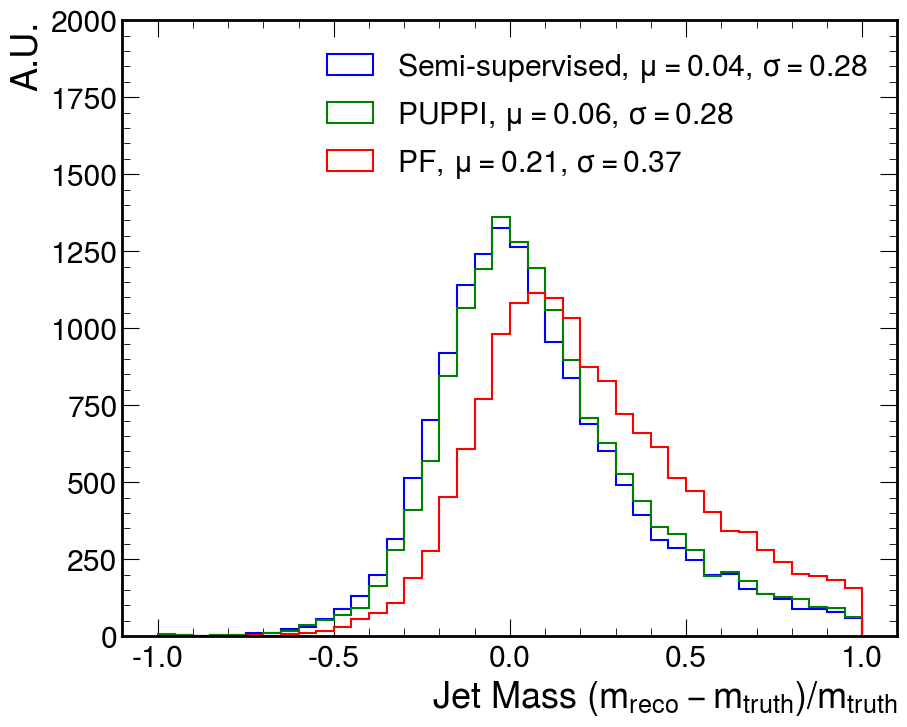

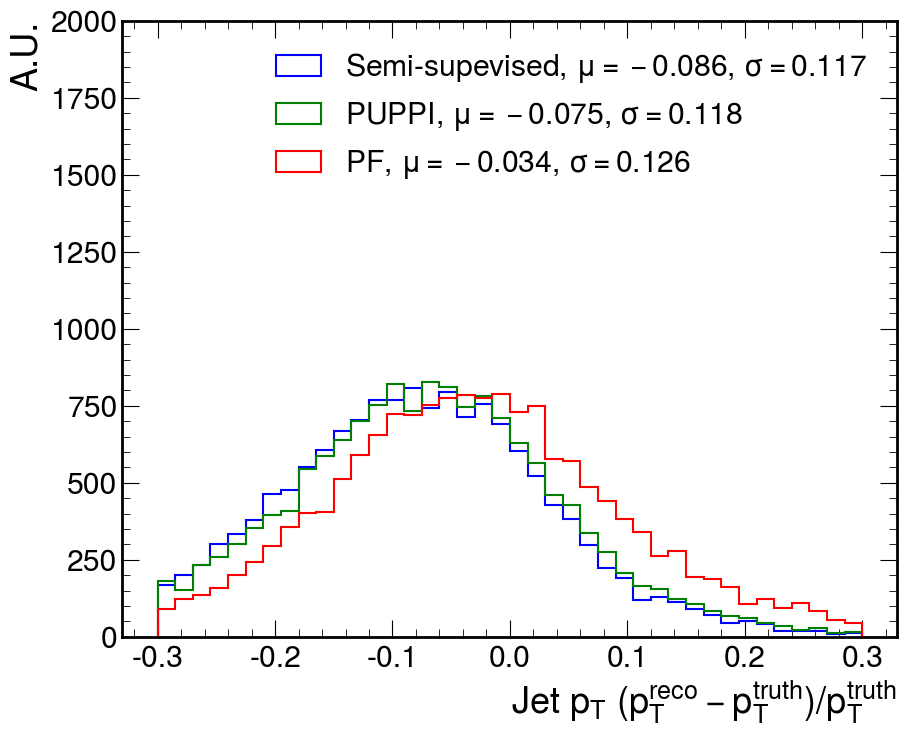

<Figure size 1000x1000 with 0 Axes>

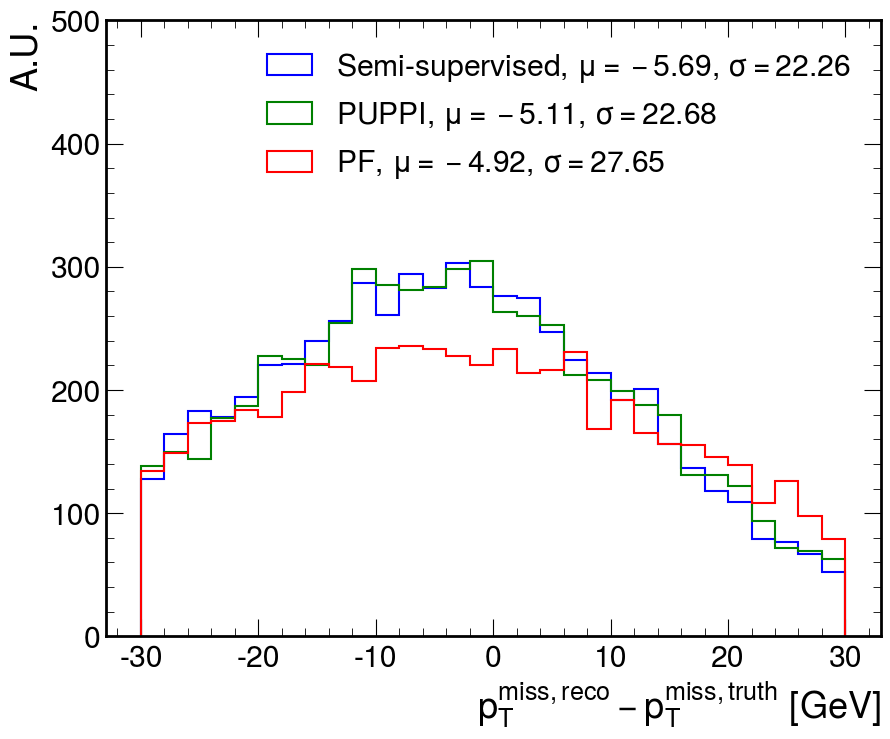

<Figure size 1000x1000 with 0 Axes>

In [22]:
def getResol(input):
    return (np.quantile(input, 0.84) - np.quantile(input, 0.16))/2

def getStat(input):
    return float(np.median(input)), float(getResol(input))

performances_jet_pred0 = performances_jet_pred['gated_boost']
#performances_jet_pred1 = performances_jet_pred['gated_noboost']
#performances_jet_pred2 = performances_jet_pred['graphsage_boost']
#performances_jet_pred3 = performances_jet_pred['graphsage_noboost']
#performances_jet_pred4 = performances_jet_pred['gated_boost_sp']


mets_pred0 = mets_pred['gated_boost']
#mets_pred1 = mets_pred['gated_noboost']
#mets_pred2 = mets_pred['graphsage_boost']
#mets_pred3 = mets_pred['graphsage_noboost']
#mets_pred4 = mets_pred['gated_boost_sp']

linewidth=1.5


%matplotlib inline
plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,8))
mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_pred0])
plt.hist(mass_diff, bins=40, range=(-1,1), histtype='step', color='blue', linewidth=linewidth, density=False, label=r'Semi-supervised, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mass_diff))))
mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_puppi])
plt.hist(mass_diff, bins=40, range=(-1,1), histtype='step', color='green', linewidth=linewidth, density=False, label=r'PUPPI, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mass_diff))))
mass_diff = np.array([getattr(perf, "mass_diff") for perf in performances_jet_puppi_wcut])
plt.hist(mass_diff, bins=40, range=(-1,1), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PF, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mass_diff))))
#plt.xlim(-1.0,1.3)
plt.xlabel(r"Jet Mass $(m_{reco} - m_{truth})/m_{truth}$")
plt.ylabel('A.U.')
plt.ylim(0, 2000)
plt.legend()
plt.savefig("Jet_mass_diff.pdf")
plt.show()


#%matplotlib inline
fig = plt.figure(figsize=(10,8))

pt_diff = np.array([getattr(perf, "pt_diff") for perf in performances_jet_pred0])
plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='blue', linewidth=linewidth, density=False, label=r'Semi-supevised, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(pt_diff))))
pt_diff = np.array([getattr(perf, "pt_diff") for perf in performances_jet_puppi])
plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='green', linewidth=linewidth, density=False, label=r'PUPPI, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(pt_diff))))
pt_diff = np.array([getattr(perf, "pt_diff") for perf in performances_jet_puppi_wcut])
plt.hist(pt_diff, bins=40, range=(-0.3,0.3), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PF, $\mu={:10.3f}$, $\sigma={:10.3f}$'.format(*(getStat(pt_diff))))
#plt.xlim(0,40)
plt.ylim(0, 2000)
plt.xlabel(r"Jet $p_{T}$ $(p^{reco}_{T} - p^{truth}_{T})/p^{truth}_{T}$")
plt.ylabel('A.U.')
plt.legend()
plt.show()
plt.savefig("Jet_pT_diff.pdf")


# MET resolution
#%matplotlib inline

fig = plt.figure(figsize=(10,8))
mets_diff = (np.array(mets_pred0) - np.array(mets_truth))
plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='blue', linewidth=linewidth, density=False, label=r'Semi-supervised, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))
mets_diff = (np.array(mets_puppi) - np.array(mets_truth))
plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='green', linewidth=linewidth, density=False, label=r'PUPPI, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))
mets_diff = (np.array(mets_puppi_wcut) - np.array(mets_truth))
plt.hist(mets_diff, bins=30, range=(-30,30), histtype='step', color='red', linewidth=linewidth, density=False, label=r'PF, $\mu={:10.2f}$, $\sigma={:10.2f}$'.format(*(getStat(mets_diff))))

plt.xlabel(r"$p^{miss, reco}_{T} - p^{miss, truth}_{T}$ [GeV]")
plt.ylabel('A.U.')
plt.ylim(0,500)
plt.legend()
plt.show()
plt.savefig("MET_diff.pdf")


## event image

In [23]:
ifile = "/Workdir/data_pickle/dataset_graph_puppi_8000"
fp = open(ifile, "rb")
dataset = joblib.load(fp)
generate_neu_mask(dataset)
generate_mask(dataset)
data = DataLoader(dataset, batch_size=1)

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [24]:
iters = iter(data)

eta_truths = np.array([])
phi_truths = np.array([])
charge_truths = np.array([])
pt_truths = np.array([])
pt_truth_scaled = np.array([])


## LV particles
eta_lvs = np.array([])
phi_lvs = np.array([])
charge_lvs = np.array([])

pt_lvs = np.array([])
pt_lv_scaled = np.array([])

pt_lv_puppi = np.array([])
pt_lv_puppi_scaled = np.array([])

pt_lv_pf = np.array([])
pt_lv_pf_scaled = np.array([])

pt_lv_pred = np.array([])
pt_lv_pred_scaled = np.array([])


njets = 0
model_gated_boost.to('cuda:0')
#odel_gated_boost_sp.to('cuda:0')

for i in range(1000):
    if i%1==0:
        print(f"finished {i}")
    res = iters.next()

    res_gpu = res.to(device)

    model_gated_boost.eval()
    pred_gpu = model_gated_boost.forward(res_gpu)
    pred = np.array(pred_gpu[0][:,0].cpu().detach())
    
    #a = np.vstack(pred)
    #dt = xgb.DMatrix(np.vstack(a))
    #pred_post = xgbmodel_load.predict(dt)
    
    #model_gated_boost_sp.eval()
    #predsl_gpu = model_gated_boost_sp.forward(res_gpu)
    #predsl = np.array(predsl_gpu[0][:,0].cpu().detach())

    pt  = np.array(res.x[:,2].cpu().detach())
    eta = np.array(res.x[:,0].cpu().detach())
    phi = np.array(res.x[:,1].cpu().detach())

    #uppi = np.array(res.x[:,res.num_feature_actual[0].item()-1].cpu().detach())
    puppi = np.array(res.pWeight.cpu().detach())
    #print("puppi weights", puppi)
    #print(puppi.shape)
    
    pt_truth = np.array(res.GenPart_nump[:,2].cpu().detach())
    eta_truth = np.array(res.GenPart_nump[:,0].cpu().detach())
    phi_truth = np.array(res.GenPart_nump[:,1].cpu().detach())
    charge_truth = np.array(res.GenPart_nump[:,4].cpu().detach())
    
    charge_index = res.Charge_index[0]
    charge = np.zeros(pt.shape[0])
    charge[charge_index] = 1

    jets_pred  = clusterJets(pt_truth, eta_truth, phi_truth)
    if len(jets_pred) == 0:
        continue
    njets += 1
    jet1st_pt  = jets_pred[0].pt
    jet1st_eta = jets_pred[0].eta
    jet1st_phi = jets_pred[0].phi 
    
    print("pt, eta, phi", jet1st_pt, jet1st_eta, jet1st_phi)

    #selection = (abs(eta-jet1st_eta) < 0.3 ) & (abs(deltaPhi(phi-jet1st_phi))<0.3)
    selection = np.ones(eta_truth.shape[0], dtype=bool)
    eta_truths = np.hstack([eta_truths, (eta_truth-jet1st_eta)[selection]])
    phi_truths = np.hstack([phi_truths, (phi_truth-jet1st_phi)[selection]])
    charge_truths = np.hstack([charge_truths, charge_truth[selection]])
    pt_truth_scaled = np.hstack([pt_truth_scaled, pt_truth[selection] / jet1st_pt])
    
    # LV after puppi, ssl-gnn
    #election_lv = (selection & (truth==1) & (charge==0))
    selection_lv = np.ones(eta.shape[0], dtype=bool)
    eta_lvs = np.hstack([eta_lvs, (eta-jet1st_eta)[selection_lv]])
    phi_lvs = np.hstack([phi_lvs, deltaPhiNew(phi-jet1st_phi)[selection_lv]])

    pt_lvs = np.hstack([pt_lvs, pt[selection_lv]])
    pt_lv_scaled = np.hstack([pt_lv_scaled, (pt/jet1st_pt)[selection_lv]])
    
    pt_lv_puppi = np.hstack([pt_lv_puppi, (pt*puppi)[selection_lv]])
    pt_lv_puppi_scaled = np.hstack([pt_lv_puppi_scaled, (pt*puppi)[selection_lv]/jet1st_pt])
    
    pt_lv_pred = np.hstack([pt_lv_pred, (pt*pred)[selection_lv]])
    pt_lv_pred_scaled = np.hstack([pt_lv_pred_scaled, (pt*pred)[selection_lv]/jet1st_pt])

    
pt_lv_puppi_scaled[pt_lv_puppi<0.]=0
pt_lv_puppi[pt_lv_puppi<0.]=0

finished 0
puppi weights [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         1.         0.
 1.         0.99609375 0.9370117  0.81152344 1.         1.
 0.         1.         1.         1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.99609375 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.      

pt, eta, phi 79.444306673218 -3.1893689521928597 -1.1158031649699716
finished 32
puppi weights [0. 0. 0. ... 0. 0. 0.]
pt, eta, phi 112.55859970158095 -1.6669061322010281 -2.0255659497967944
finished 33
puppi weights [0. 0. 0. ... 0. 0. 0.]
pt, eta, phi 92.9889494196556 0.9472134104585245 -1.884732529478665
finished 34
puppi weights [0.8745117 0.        0.        ... 0.        0.        0.       ]
pt, eta, phi 85.57243760499213 -0.4350133683983 1.3963008289797685
finished 35
puppi weights [0.984375   0.         0.         0.         0.         0.
 0.         0.78027344 0.7607422  1.         1.         0.
 0.99609375 1.         0.         1.         1.         1.
 1.         1.         0.         1.         0.60791016 1.
 1.         1.         1.         1.         0.         0.
 1.         1.         0.99609375 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.99609375 0.         0.         0.
 0.         0.         0.         

pt, eta, phi 158.65014990365484 -0.7941600092870275 -3.0878076969741457
finished 66
puppi weights [0.         0.99609375 0.         0.         0.         0.
 0.         0.         0.         0.99609375 0.         0.
 0.         0.         0.         1.         1.         0.
 1.         1.         1.         1.         1.         1.
 0.         1.         1.         1.         1.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.   

pt, eta, phi 114.81105435099587 -1.737142746793114 2.777163353227749
finished 97
puppi weights [0.         0.         0.         0.         0.         0.99609375
 0.         0.         0.         0.         0.60009766 0.
 0.         0.         0.         1.         0.         1.
 1.         1.         1.         1.         0.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         

pt, eta, phi 75.82953747511925 -1.4479268880866625 0.2740909085862882
finished 125
puppi weights [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.99609375 0.         0.         1.         1.         1.
 1.         1.         1.         1.         1.         0.
 0.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.    

finished 157
puppi weights [0.984375 0.       0.       ... 0.       0.       0.      ]
pt, eta, phi 180.65287878325958 0.25084336619651565 2.118413585993894
finished 158
puppi weights [0.         0.         0.         0.         0.         0.
 0.         0.         0.9765625  0.99609375 0.         0.
 0.         0.         0.         0.         0.         1.
 0.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.         1.         1.
 1.         1.         1.         0.         0.78808594 1.
 1.         1.         1.         1.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.  

puppi weights [0. 0. 0. ... 0. 0. 0.]
pt, eta, phi 102.1368457247684 -2.8515805049805336 -0.33875441601800294
finished 187
puppi weights [0.         0.         0.         0.         0.         0.
 0.98828125 0.9453125  0.         0.99609375 0.         0.99609375
 0.         0.         1.         1.         1.         0.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.         1.         0.72558594
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.         0.98828125 1.
 1.         1.         1.         1.         0.         1.
 1.         1.         1.         1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.99609375 0.         0.
 0.         0.         0.         0.         0.         0.
 0.96484375 0.         0.         0.         0.         0.
 0.         0.       

finished 215
puppi weights [0. 0. 0. ... 0. 0. 0.]
pt, eta, phi 99.53323279900437 0.3044181846063759 2.4853957908360584
finished 216
puppi weights [0.         0.         0.         0.7373047  0.         0.
 0.98828125 0.         0.9453125  0.         0.         0.99609375
 0.         1.         1.         0.89404297 1.         1.
 1.         1.         0.         0.         0.         0.
 1.         1.         1.         1.         1.         0.99609375
 1.         0.         1.         1.         0.         1.
 1.         0.         1.         0.94140625 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.98046875 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        

finished 243
puppi weights [0.         0.         0.         1.         0.         0.
 1.         0.         0.         0.         0.         1.
 1.         1.         0.         1.         1.         1.
 0.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.81152344 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

puppi weights [0.         0.         0.         0.         0.         0.9921875
 0.83935547 0.9453125  0.         0.83154297 1.         1.
 1.         1.         1.         1.         1.         0.98046875
 1.         1.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.99609375 0.99609375 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         1.  

puppi weights [0.         0.         0.         0.         0.         0.8588867
 0.         0.         1.         1.         0.9135742  1.
 1.         0.         1.         0.         1.         0.81152344
 1.         0.         1.         1.         1.         1.
 1.         0.         0.         1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.95703125 0.         0.         0.         0.99609375
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.9291992
 0.         0.         0.         0.         0.         0.
 0.         

pt, eta, phi 93.16866804877229 -1.7168636749666297 -2.4889366756270235
finished 328
puppi weights [0.         0.99609375 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         1.
 0.         0.         1.         1.         1.         1.
 1.         1.         1.         1.         0.         1.
 1.         1.         1.         0.         1.         0.
 0.         0.99609375 0.95703125 0.         0.         0.99609375
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.      

pt, eta, phi 115.19814539622877 -0.820152714743364 -1.0801656028223228
finished 355
puppi weights [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.7919922
 1.         1.         1.         1.         1.         0.99609375
 1.         1.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.99609375 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.85498047 0.         0.
 0.         0.         0.         0.         0.         0.
 0

puppi weights [0.90185547 0.         0.83154297 0.99609375 0.99609375 0.
 0.7138672  0.         0.         0.         0.         1.
 0.9921875  1.         1.         1.         1.         1.
 1.         0.5019531  1.         1.         0.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.984375   0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.99609375 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.99609375 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.      

pt, eta, phi 152.10792479891592 -1.5494426234162426 -0.5365773418876527
finished 404
puppi weights [0.99609375 0.         0.         0.         0.         0.
 1.         1.         1.         0.         1.         1.
 1.         1.         1.         1.         0.         0.92529297
 1.         1.         1.         1.         1.         1.
 0.         1.         1.         1.         0.         1.
 1.         1.         0.         0.         0.         0.
 0.         0.984375   0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.99609375
 0.         0.         0.         0.         0.         0.


puppi weights [0.         0.         0.         0.         0.         0.
 0.         0.7919922  0.99609375 0.91748047 0.         0.
 0.         0.99609375 0.         0.         1.         0.
 0.         1.         1.         0.8276367  1.         0.
 1.         1.         1.         0.         0.         1.
 1.         0.         1.         0.76464844 1.         1.
 1.         1.         1.         1.         0.9609375  1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.         1.         0.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.      

pt, eta, phi 152.26507096847652 -0.07636384206356253 1.883445061300405
finished 454
puppi weights [0.99609375 0.         0.         0.         0.         1.
 1.         1.         1.         0.         1.         0.99609375
 0.98828125 0.98828125 0.         1.         0.         1.
 1.         1.         1.         0.         0.97265625 1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.5449219  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.60009766 0.         0.
 0.99609375 0.         0.         0.         0.         0.
 0.         0.         1.         1.         0.99609375 0.99609375
 1.         0.         0.99609375 0.8432617  1.         1.
 1.         1.         1.         1.         1.         1.
 

pt, eta, phi 157.19565934463895 -0.2696499446969998 -1.5648196551621076
finished 479
puppi weights [1.         1.         0.         0.         0.         0.
 0.         0.         0.         0.99609375 0.         0.
 0.99609375 0.6743164  1.         1.         1.         0.
 1.         1.         1.         1.         1.         0.98046875
 1.         0.         1.         1.         0.84716797 0.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.         1.         1.         1.
 1.         1.         1.         1.         0.         0.
 1.         1.         0.         0.         0.         0.
 0.         0.99609375 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.8745117
 0.         0.         0.         0.         0.         0.94

puppi weights [0.99609375 0.99609375 0.8354492  ... 0.         0.         0.        ]
pt, eta, phi 220.2604723774429 1.206609257566382 0.8957187703857623
finished 503
puppi weights [0.         0.         0.         0.         0.7763672  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.         1.         1.         1.         1.
 1.         1.         1.         0.         1.         1.
 1.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.     

finished 525
puppi weights [0.         0.         0.         0.         0.         0.
 1.         1.         0.8276367  1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.    

finished 548
puppi weights [0.         0.         0.         0.         0.73339844 0.
 0.93310547 0.         0.         0.         0.94921875 0.
 0.         0.         0.         1.         1.         1.
 1.         0.         1.         1.         1.         0.9921875
 1.         1.         1.         1.         1.         1.
 1.         1.         0.         0.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.         0.         0.         0.         0.         0.98828125
 0.         0.         0.         0.         0.         0.
 0.         0.65478516 0.6586914  0.         0.         0.96484375
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.97265625 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.   

puppi weights [0. 0. 0. ... 0. 0. 0.]
pt, eta, phi 134.22429592265806 -0.7210720716968577 2.022619078699415
finished 569
puppi weights [0.99609375 0.88623047 0.         0.         0.         0.
 0.         0.         0.         0.         0.95703125 0.95703125
 0.99609375 0.         1.         0.         0.8432617  0.
 1.         1.         0.96484375 1.         1.         1.
 1.         1.         1.         1.         0.67822266 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.96875    0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.89404297 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.811523

finished 591
puppi weights [0.99609375 0.         0.         0.         0.         0.99609375
 0.         0.         0.9921875  0.         1.         0.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.98046875
 0.99609375 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.81152344 0.9921875  0.984375   0.93310547 0.         0.9370117
 0.98046875 0.         0.96875    1.         1.         1.
 1.         1.         0.99609375 1.         1.         1.
 1.   

finished 613
puppi weights [0.         0.8276367  0.         0.         0.         0.
 0.         0.         0.         1.         1.         1.
 0.         1.         0.         1.         1.         1.
 1.         0.         1.         1.         0.9921875  1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.99609375
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.       

pt, eta, phi 111.28079001373159 -0.697569129460858 -1.599919555382165
finished 635
puppi weights [0.         0.         0.         0.         0.         0.
 0.         0.97265625 0.         0.         0.74121094 0.
 0.99609375 1.         0.         1.         1.         0.
 1.         1.         1.         1.         1.         0.
 1.         1.         1.         0.         1.         0.
 1.         0.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.         0.         0.99609375 0.         0.         0.99609375
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.99609375 1.         0.         0.         0.
 0.         0.         0.         0.99609375 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.       

pt, eta, phi 74.79114634312796 0.3413221659994861 -2.7208389222402367
finished 656
puppi weights [0.9921875  0.         0.         0.         0.96484375 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.9135742  0.         0.
 0.         1.         1.         1.         0.         1.
 1.         0.         0.         1.         1.         1.
 1.         1.         1.         0.88623047 1.         1.
 1.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.99609375 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.    

finished 677
puppi weights [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.         1.         1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.78027344 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

puppi weights [0.         0.         0.         0.92529297 0.         0.7919922
 0.         1.         1.         1.         1.         0.
 1.         0.         1.         1.         1.         0.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.9609375  1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.984375
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

pt, eta, phi 182.48708673365178 -1.1272991303799875 0.5670498049766463
finished 716
puppi weights [0.         0.         0.8666992  0.99609375 0.         0.
 0.         0.         1.         1.         1.         0.984375
 1.         1.         1.         1.         1.         0.
 1.         1.         1.         1.         1.         0.
 1.         1.         0.99609375 1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.7451172  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.9057617  0.         0.         0.         0.         0.
 0.99609375 0.99609375 0.99609375 0.         0.         0.
 0.        

pt, eta, phi 154.44106819061525 -1.0925841861045607 0.3179416013021393
finished 735
puppi weights [0.         0.         0.         0.         0.80371094 0.
 0.         0.         0.         0.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.         0.         1.         1.         0.         0.99609375
 1.         1.         1.         1.         0.90185547 1.
 1.         1.         1.         1.         0.         1.
 1.         1.         0.         1.         1.         0.
 1.         0.         0.         1.         1.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.      

finished 753
puppi weights [0.74902344 0.         0.         0.         0.9921875  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.99609375 1.         0.         0.         1.         1.
 1.         0.         1.         1.         1.         1.
 0.         1.         1.         0.         0.         1.
 1.         0.953125   1.         1.         1.         0.
 1.         0.         1.         0.         0.         0.
 1.         0.         0.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

finished 772
puppi weights [0.87841797 0.         0.99609375 0.         0.         0.78027344
 1.         1.         0.         1.         1.         1.
 1.         1.         1.         1.         1.         0.9135742
 1.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.7919922  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.99609375 0.         0.
 0.88623047 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.82373047 0.         0.99609375
 1.         0.         0.         1.         1.         1.
 1.         1.         1.         0.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.   

finished 791
puppi weights [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.80371094 0.         0.
 1.         0.         1.         1.         1.         0.
 0.6274414  1.         1.         1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

finished 809
puppi weights [0. 0. 0. ... 0. 0. 0.]
pt, eta, phi 122.62497825299015 -0.7258957642302976 -3.049690172774428
finished 810
puppi weights [0.         0.7451172  0.98828125 0.         0.         0.98828125
 0.         0.         0.         0.         1.         0.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.99609375 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.99609375 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.   

puppi weights [0.         0.         0.         0.         0.         1.
 0.         0.         0.         0.         0.8276367  1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.81591797
 1.         1.         0.         1.         1.         1.
 1.         1.         1.         1.         0.         0.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.9291992  0.         0.69433594 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.90966797 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         

finished 844
puppi weights [0.9765625  0.99609375 0.99609375 0.         0.         0.
 0.87060547 0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.         1.
 1.         1.         0.         0.80371094 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.    

finished 861
puppi weights [0.         0.99609375 1.         ... 0.         0.41577148 0.2548828 ]
pt, eta, phi 188.48584710134548 1.025337051632263 1.3270030262324388
finished 862
puppi weights [0.         0.         0.         0.99609375 0.         0.5566406
 0.         0.         0.         0.         0.         0.
 0.         0.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.         1.         1.         1.         1.
 0.93310547 1.         1.         0.99609375 0.9921875  0.9609375
 0.         1.         1.         1.         1.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.8901367  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0

pt, eta, phi 121.27168476625933 0.6841895627210145 0.6624376446952515
finished 879
puppi weights [0.7451172  0.         0.99609375 ... 0.41577148 0.         0.        ]
pt, eta, phi 144.27766130933114 1.023843370373287 2.405223803771955
finished 880
puppi weights [0.         0.         0.         0.         0.         0.98828125
 0.         0.         0.         1.         1.         0.
 1.         0.         0.         1.         1.         1.
 0.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.56884766 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.      

puppi weights [0.         0.99609375 0.82373047 0.         0.         0.60791016
 0.99609375 0.         0.99609375 0.         0.7529297  0.
 1.         1.         0.         1.         1.         1.
 0.         1.         1.         0.         0.         0.66259766
 1.         1.         0.99609375 1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.99609375 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0. 

pt, eta, phi 178.77156865201977 0.7547796929445598 2.5146479379788365
finished 913
puppi weights [0.         0.         0.72558594 ... 0.63134766 0.         0.        ]
pt, eta, phi 61.88467669822787 1.272250115276539 -1.3372085957489688
finished 914
puppi weights [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.984375
 0.         0.         0.         0.         1.         1.
 1.         0.         0.         1.         0.         1.
 1.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.       

finished 930
puppi weights [0. 0. 0. ... 0. 0. 0.]
pt, eta, phi 132.76671313662177 -1.6482605304165747 1.9855244348840226
finished 931
puppi weights [0.         0.         0.         0.         0.         0.
 0.         1.         0.         1.         1.         1.
 0.80371094 1.         1.         1.         1.         1.
 1.         1.         1.         0.         1.         1.
 1.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.

pt, eta, phi 93.71724359922192 -0.9115141748653636 -1.7180336527993738
finished 948
puppi weights [0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         1.         1.
 0.         1.         0.         0.         0.         1.
 1.         1.         1.         1.         0.         1.
 1.         0.99609375 1.         0.70996094 1.         1.
 1.         1.         0.         0.         1.         1.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.   

finished 964
puppi weights [0.         0.         0.         0.         0.         0.47460938
 0.         0.         0.         0.         0.         1.
 1.         0.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.       

finished 981
puppi weights [0.44311523 0.         0.9921875  0.         0.         0.
 0.         0.         0.         0.98046875 0.         0.
 0.98046875 0.         0.         0.         0.         1.
 1.         1.         0.         0.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.         1.
 1.         1.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.99609375 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.9921875  0.         0.99609375 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.9765625
 0.         0.         0.         0.         0.         0.
 0.         0.        

finished 997
puppi weights [0.         0.         0.         0.         0.         0.
 0.         1.         1.         1.         0.89404297 1.
 1.         1.         1.         1.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.6586914  0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.5566406  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.
 0.         0.         0.    

In [153]:
print(pt_lv_scaled)
np.where(pt_lv_puppi_scaled!=0)

[0.00406537 0.00438321 0.0042477  ... 0.00212336 0.01349796 0.00864093]


(array([    9,    10,    11, ..., 39778, 39789, 39801]),)

In [154]:
pt_lv_puppi_scaled[9]

0.002455363282933831

## LV particles

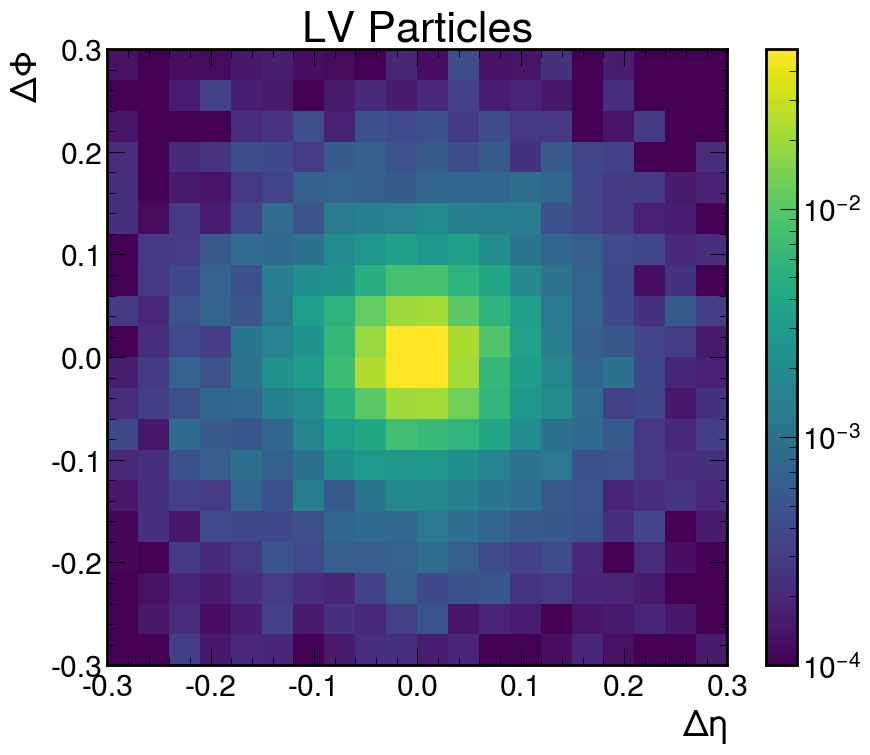

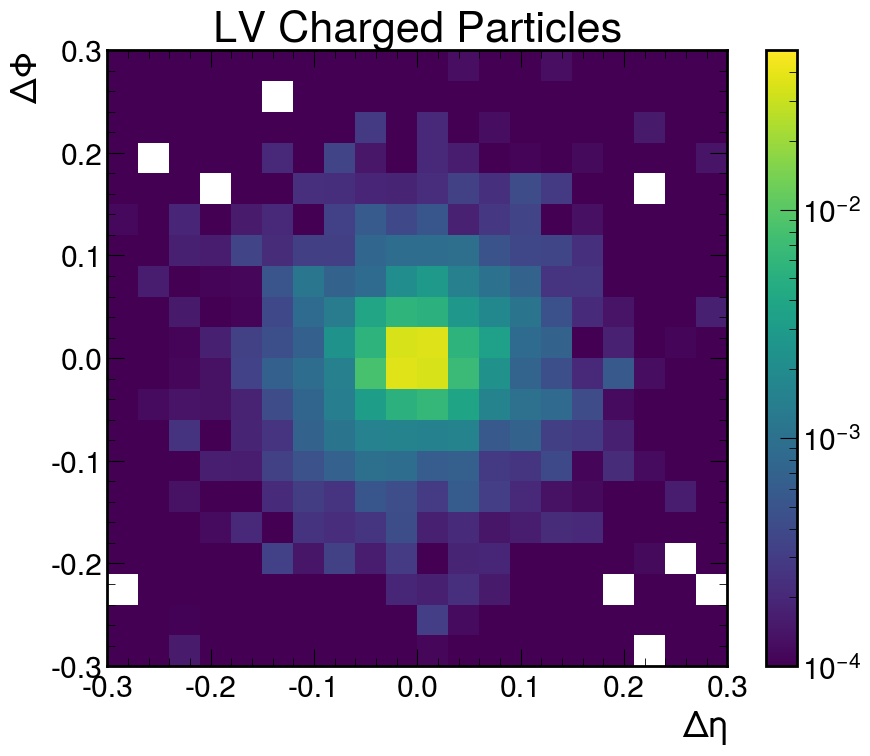

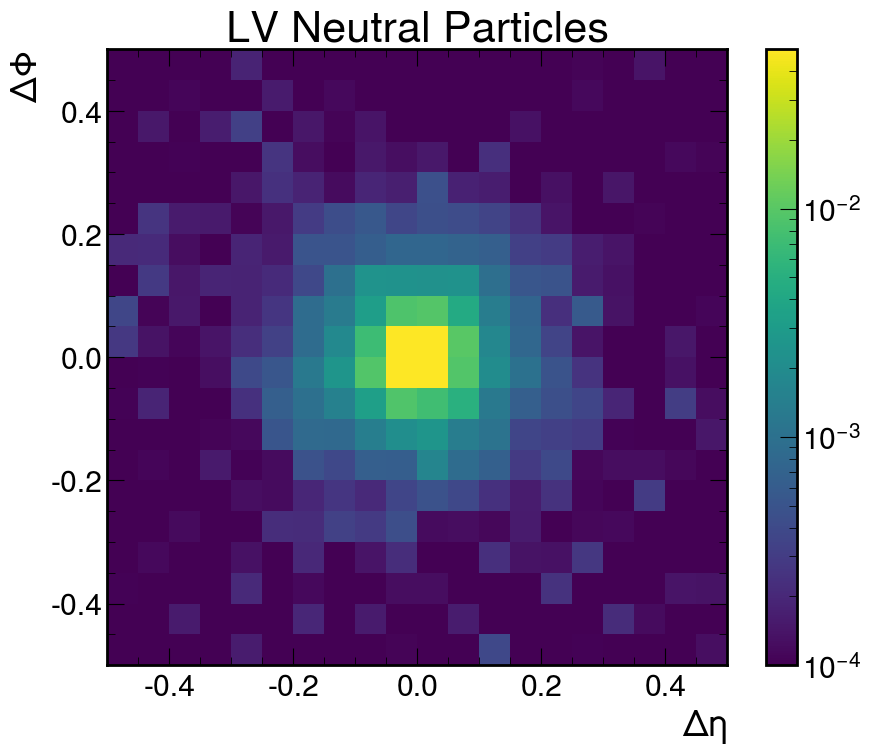

In [26]:
%matplotlib inline
plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,8))
a = plt.hist2d(eta_truths, phi_truths, bins=20, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_truth_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(a[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.clim(1e-4,5e-2)
plt.title('LV Particles')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.show()

fig = plt.figure(figsize=(10,8))
a = plt.hist2d(eta_truths[charge_truths==1], phi_truths[charge_truths==1], bins=20, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_truth_scaled[charge_truths==1]/njets, norm=mpl.colors.LogNorm())
plt.colorbar(a[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.clim(1e-4,5e-2)
plt.title('LV Charged Particles')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.show()

fig = plt.figure(figsize=(10,8))
a = plt.hist2d(eta_truths[charge_truths==0], phi_truths[charge_truths==0], bins=20, range=[[-0.5,0.5],[-0.5,0.5]], weights=pt_truth_scaled[charge_truths==0]/njets, norm=mpl.colors.LogNorm())
plt.colorbar(a[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.clim(1e-4,5e-2)
plt.title('LV Neutral Particles')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.show()

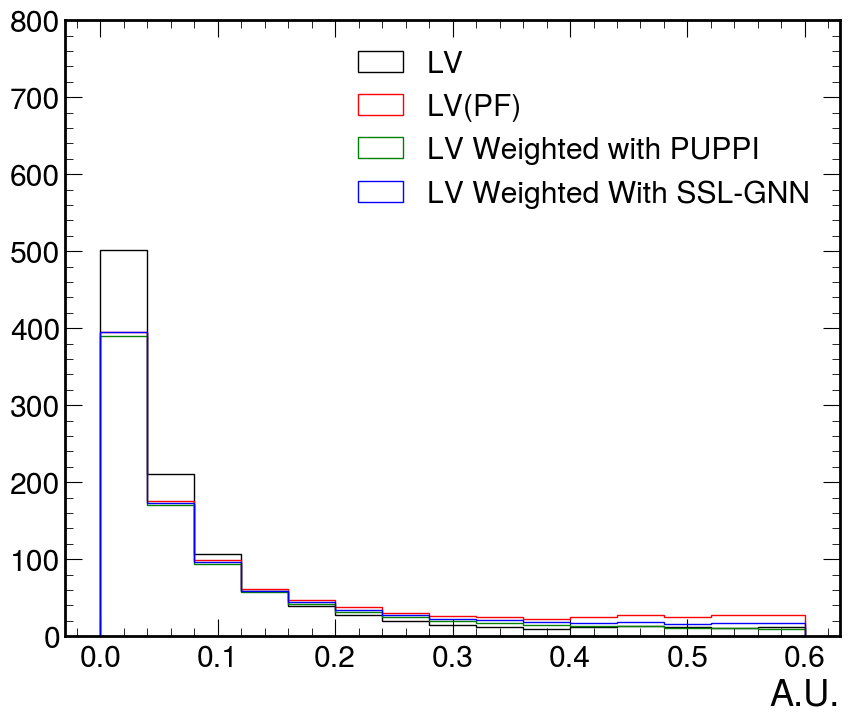

<Figure size 1000x800 with 0 Axes>

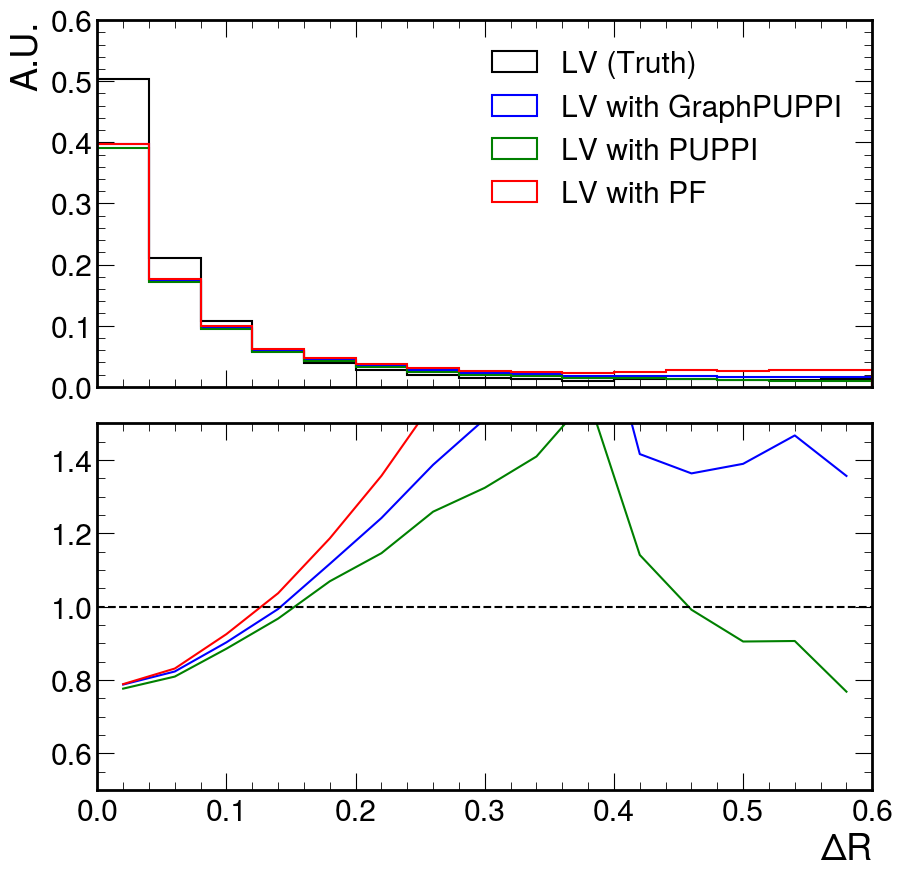

In [29]:
dR_truth = deltaRNew(eta_truths, phi_truths)
dR_lv    = deltaRNew(eta_lvs, phi_lvs)

%matplotlib inline
plt.style.use(hep.style.ROOT)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
#plt.hist(dR_truth, bins=20, range=(0,0.45), histtype='step', color='black', linestyle='-.', label=r'LV', density=True)
plt.hist(dR_truth, bins=15, range=(0,0.6),histtype='step', color='black', linestyle='-', weights=pt_truth_scaled, label=r'LV', density=False)
ax.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='red', linestyle='-', label=r'LV(PF)', weights= pt_lv_scaled, density = False)
ax.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='g', linestyle='-',   weights = pt_lv_puppi_scaled, label=r'LV Weighted with PUPPI', density=False)
ax.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='b',linestyle='-', weights = pt_lv_pred_scaled,  label=r'LV Weighted With SSL-GNN', density=False)
ax.set_xlabel(r"$\Delta R$")
ax.set_xlabel('A.U.')
ax.set_ylim(0,800)
plt.legend()
plt.show()


fig = plt.figure(figsize=(10,8))
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex=True, gridspec_kw={'height_ratios': [1,1]})
fig.subplots_adjust(hspace=0.1)
vals, bins, _ = ax1.hist(dR_truth,bins=15,range=(0,0.6),histtype='step', color='black', linestyle='-',  linewidth=1.5, weights = pt_truth_scaled / njets, label = r'LV (Truth)', density=False)
vals_pred, bins, _ = ax1.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='blue', linestyle='-', linewidth=1.5, weights = pt_lv_pred_scaled/njets,  label=r'LV with GraphPUPPI', density=False)
vals_puppi, bins, _ = ax1.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='g', linestyle='-', linewidth=1.5, weights = pt_lv_puppi_scaled/njets, label=r'LV with PUPPI', density=False)
vals_pf, bins, _ = ax1.hist(dR_lv,    bins=15, range=(0,0.6), histtype='step', color='red', linestyle='-', linewidth=1.5, weights = pt_lv_scaled/njets, label=r'LV with PF',density=False)
ax1.set_ylabel('A.U.')
ax1.set_xlim(0,0.6)
ax1.set_ylim(0,0.6)
ax1.legend()
#plt.ylim(0,0.025)
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_pred/vals, color='blue')
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_puppi/vals, color='g')
ax2.plot((bins[:-1]+bins[1:])/2.0, vals_pf/vals, color='r')
ax2.set_xlim(0,0.6)
ax2.set_xlabel(r"$\Delta R$")
ax2.set_ylim(0.5,1.5)
ax2.axhline(y=1.0, color='black', linestyle='dashed')
plt.show()

Truth LV sum:  0.8839110990294095
PUPPI PU sum:  0.8385730629857632
SSL-GNN sum:  0.861897763064171


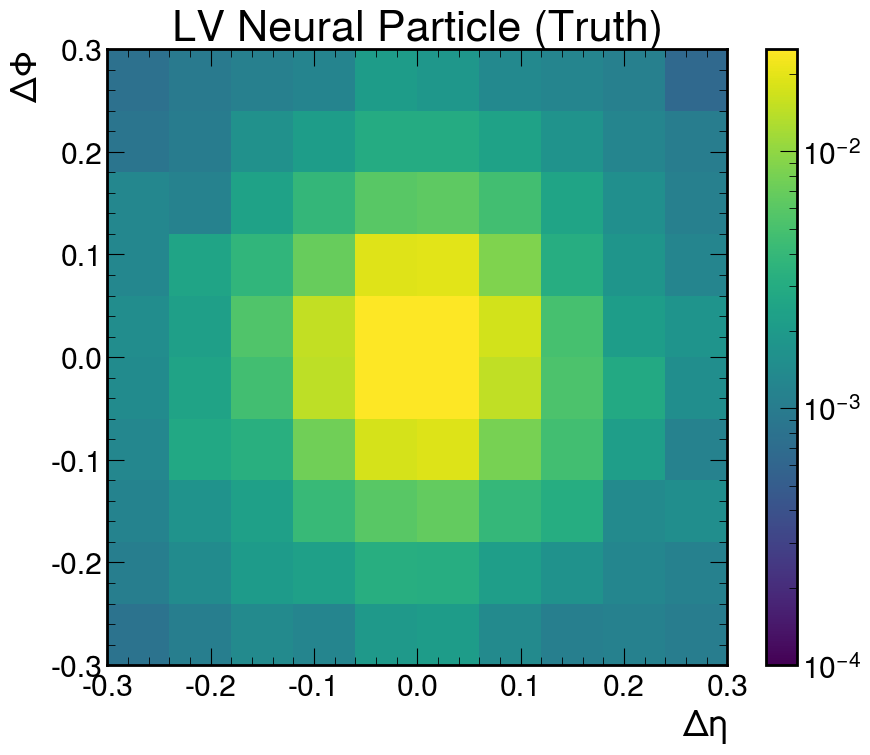

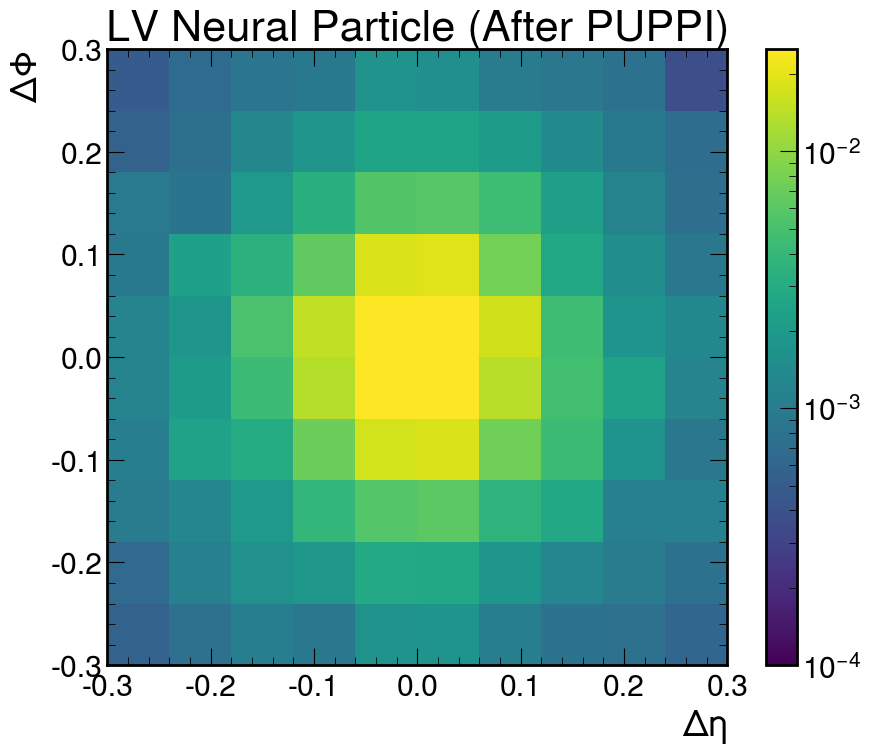

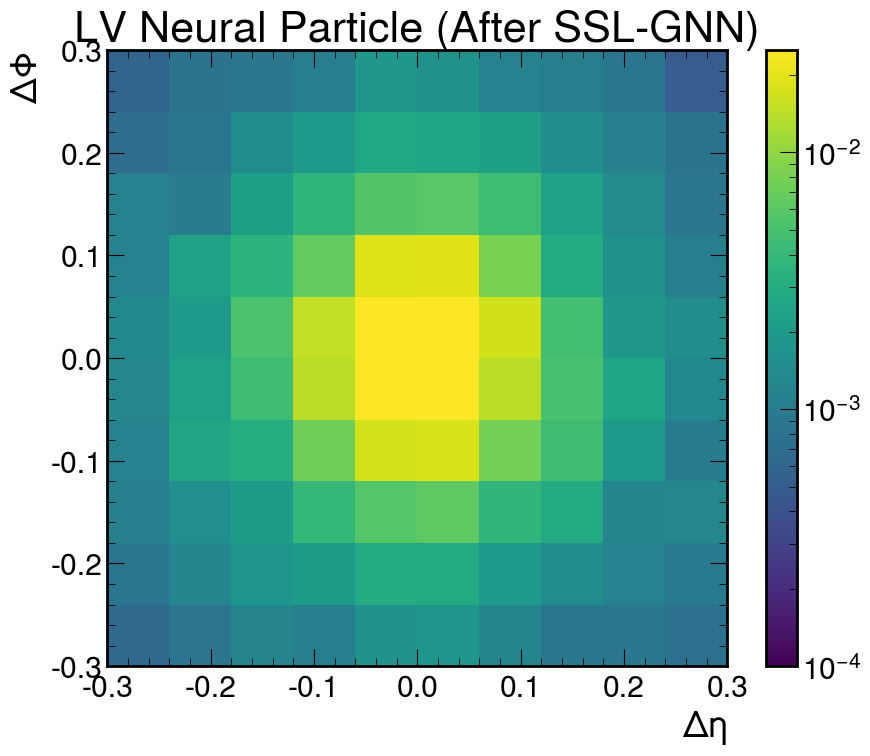

In [30]:
#
#2d plots
#
fig = plt.figure(figsize=(10,8))
results_lv = plt.hist2d(eta_lvs, phi_lvs, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_lv_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(results_lv[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('LV Neural Particle (Truth)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(1e-4,2.5e-2)
print("Truth LV sum: ", np.sum(results_lv[0]))

fig = plt.figure(figsize=(10,8))
results_puppi = plt.hist2d(eta_lvs, phi_lvs, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_lv_puppi_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(results_puppi[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('LV Neural Particle (After PUPPI)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(1e-4,2.5e-2)
print("PUPPI PU sum: ", np.sum(results_puppi[0]))

fig = plt.figure(figsize=(10,8))
results_pred = plt.hist2d(eta_lvs, phi_lvs, bins=10, range=[[-0.3,0.3],[-0.3,0.3]], weights=pt_lv_pred_scaled/njets, norm=mpl.colors.LogNorm())
plt.colorbar(results_pred[3])
#plt.xlim(-4.0,4.0)
#plt.xscale('log')
#plt.zscale('log')
plt.title('LV Neural Particle (After SSL-GNN)')
plt.xlabel(r'$\Delta\eta$')
plt.ylabel(r'$\Delta\Phi$')
plt.clim(1e-4,2.5e-2)
print("SSL-GNN sum: ", np.sum(results_pred[0]))